# Highly simplified real world problem

## Problem Statement

For this highly simplified inversion I am proposing to invert for the maximum snow mass in 2017 in the Sequoia/Kings Canyon parks area.

The image below illustrates the real world problem. Green-white-red colours indicate SWE, with green = 0 and red = 3m. The yellow pins are GPS stations. I have drawn two black circles onto this map, the north one is the "Kings Canyon Disk" and the south one is the "Sequoia Disk". I would like to invert the southern-most GPS stations for the mass of snow in Sequoia.

<img src="Map_Sequoia_Kings.png">

## Part one: feasibility

If we select the four GPS stations in the south, and invert them, will they be influenced by the Kings Canyon Disk?

To test, calculate the maximum impact of the Kings Canyon disk on the northern most GPS station (P572).

Conclusion, as evidenced in the plot below: We cannot use P572 as it has almost equal contributions from Kings and Sequoia disks. We can only use P571, P573 and P465. And possibly P467 (BUT TECTONICS IN ALABAMA HILLS?!?).

The other conclusion is that the signal will be small (<5mm) and difficult to extract from the GPS background noise. 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import seaborn as sns

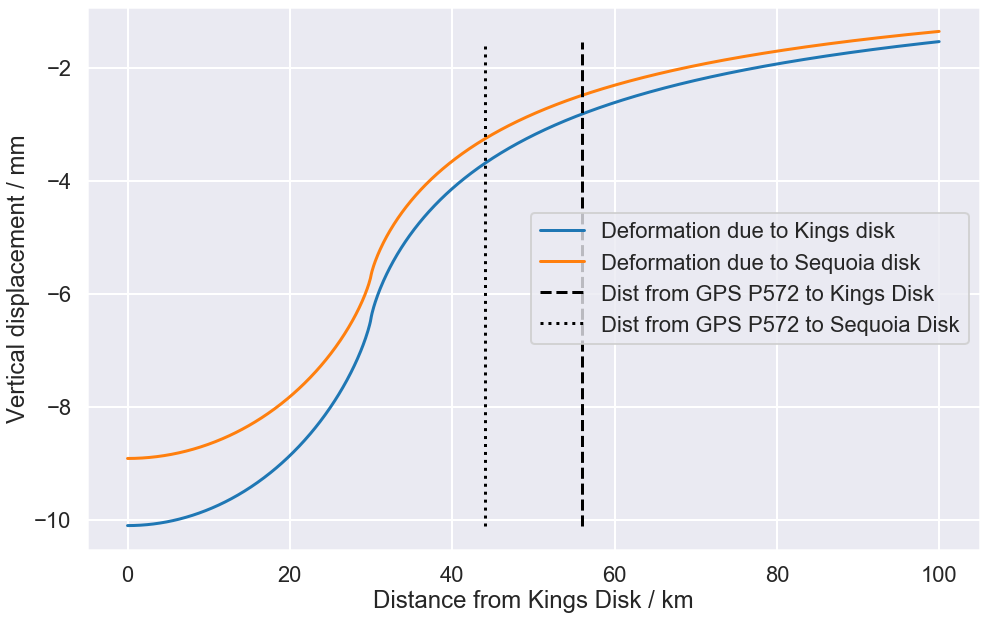

In [92]:
def calc_deformation_disk(M,lamda,mew,alpha,r):
    ''' 
    Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mew.
    M: mass of the disk, kg
    lamda: Lame parameter of substrate
    mew: shear modulus of substrate
    alpha: disk radius, in metres
    r: array of distances from centre of disk at which to calculate solution. In metres. eg r = np.linspace(0,50*10**3,num=1000) to go to 50km distance.
    
    '''
    sigma=lamda+2*mew
    nabla=lamda + mew
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M*g* (sigma/(np.pi**2 * mew * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )
    
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mew * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm

g = 9.81
lamda_gran = 25*10**9 # Lame parameter of granite
mew_gran = 40*10**9 # Shear modulus of granite
r = np.linspace(0,100*10**3,num=1000)

alpha_Kings = 30*10**3
thickness_Kings = 1.7
M_Kings = np.pi * alpha_Kings**2 * thickness_Kings * 1000

alpha_Sequoia = 30*10**3
thickness_Sequoia = 1.5
M_Sequoia = np.pi * alpha_Sequoia**2 * thickness_Sequoia * 1000


defm_Kings = calc_deformation_disk(M_Kings,lamda_gran,mew_gran,alpha_Kings,r)
defm_Sequoia = calc_deformation_disk(M_Sequoia,lamda_gran,mew_gran,alpha_Sequoia,r)

sns.set_context('poster')
sns.set_style('darkgrid')


fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.plot(r/10**3,defm_Kings*10**3,label='Deformation due to Kings disk')
plt.plot(r/10**3,defm_Sequoia*10**3,label='Deformation due to Sequoia disk')
plt.plot([56,56],[np.min(defm_Kings*10**3),np.max(defm_Kings*10**3)],'k--',label='Dist from GPS P572 to Kings Disk')
plt.plot([44,44],[np.min(defm_Kings*10**3),np.max(defm_Kings*10**3)],'k:',label='Dist from GPS P572 to Sequoia Disk')

plt.xlabel('Distance from Kings Disk / km')
plt.ylabel('Vertical displacement / mm')
plt.legend()

## Part two: the data.

Plot GPS time series and extract the change over the 2016/17 snow season.

Result: from the plots below, I am eyeballing the following changes for each station:

- P571: 21 mm subsidence.
- P573: unclear; jump in middle of series.
- P465: 17 mm subsidence.
- P467: 16 mm subsidence.





In [32]:
import pandas as pd
from datetime import datetime as dt
from matplotlib.dates import date2num

def import_GPS_data_new(station_name,ref_frame='nam08',solution='pbo'):
    '''imports GPS data from station name. Returns [data, dates]. Assumes data is stored tidily in a folder called gps_data.'''
    filename = '%s.%s.%s.csv' % (station_name,solution,ref_frame)
    fileloc = 'gps_data/%s/%s' % (station_name,filename)
    print('Importing GPS data from: "%s".' % fileloc)    
    csvdata= pd.read_csv(fileloc,header=11,delimiter=',',skipinitialspace=True)
    datesgps = csvdata['Date']
    gpsdates_list = [dt.strptime(date, '%Y-%m-%d').date() for date in datesgps]    
    gpsdates = date2num(gpsdates_list)        
    print('\tSuccessfully imported GPS time series of length %i.\n' % len(gpsdates) )
    return csvdata,gpsdates


def plot_individual_gps_station_vertical(station_name,startdate=False,enddate=False):
    '''A quick plot of the vertical timeseries for an individual GPS station.
    
    Startdate: string in format 'dd/mm/yyyy'. Ditto for enddate.'''
    data,dates = import_GPS_data_new(station_name)    
    print('Plotting vertical time series for station %s.' % station_name )    
    plt.plot_date(dates,data['Vertical (mm)'])
    if startdate:
        if enddate:
            plt.xlim([dt.strptime(startdate, '%d/%m/%Y').date(),dt.strptime(enddate, '%d/%m/%Y').date()])    
    plt.title(station_name)
    plt.ylabel('Vertical motion / mm')


Importing GPS data from: "gps_data/P571/P571.pbo.nam08.csv".
	Successfully imported GPS time series of length 4691.

Plotting vertical time series for station P571.
Importing GPS data from: "gps_data/P572/P572.pbo.nam08.csv".
	Successfully imported GPS time series of length 4433.

Plotting vertical time series for station P572.
Importing GPS data from: "gps_data/P573/P573.pbo.nam08.csv".
	Successfully imported GPS time series of length 3644.

Plotting vertical time series for station P573.
Importing GPS data from: "gps_data/P465/P465.pbo.nam08.csv".
	Successfully imported GPS time series of length 4113.

Plotting vertical time series for station P465.
Importing GPS data from: "gps_data/P467/P467.pbo.nam08.csv".
	Successfully imported GPS time series of length 4566.

Plotting vertical time series for station P467.


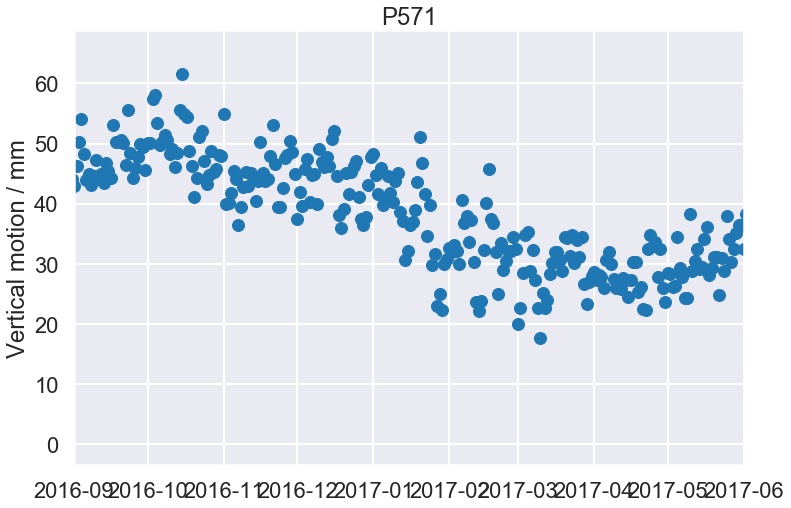

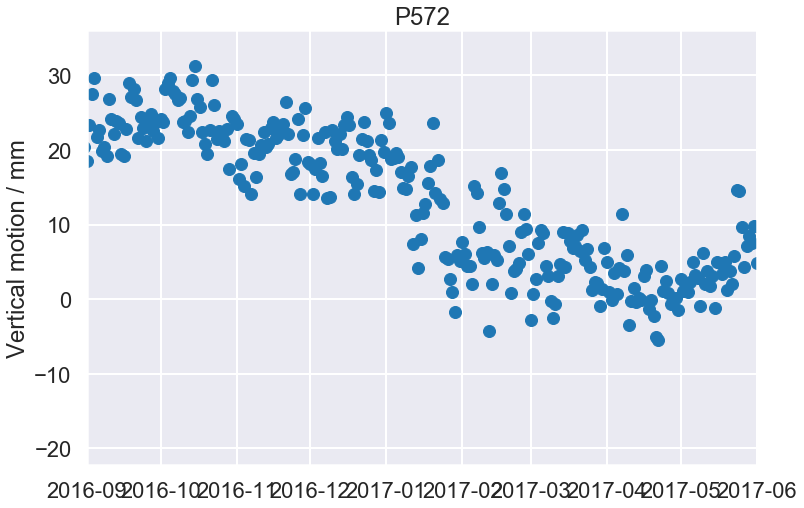

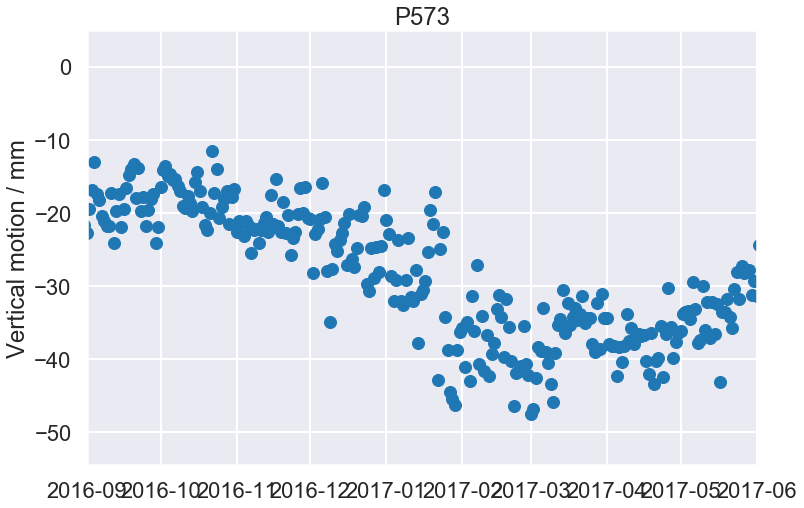

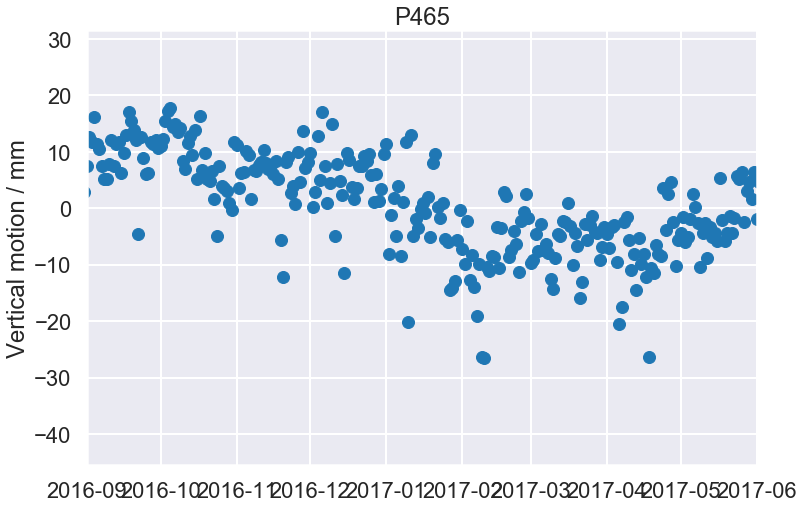

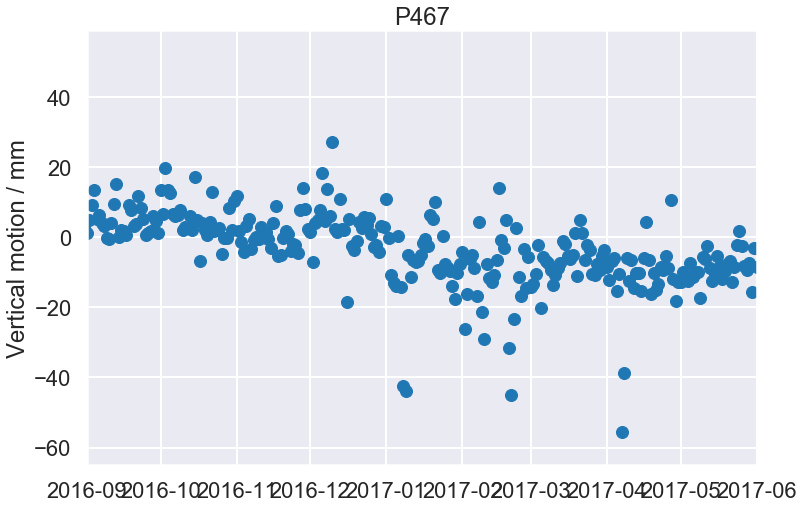

In [95]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_individual_gps_station_vertical('P571',startdate='01/09/2016',enddate='01/06/2017')

fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_individual_gps_station_vertical('P572',startdate='01/09/2016',enddate='01/06/2017')

fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_individual_gps_station_vertical('P573',startdate='01/09/2016',enddate='01/06/2017')

fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_individual_gps_station_vertical('P465',startdate='01/09/2016',enddate='01/06/2017')

fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_individual_gps_station_vertical('P467',startdate='01/09/2016',enddate='01/06/2017')



# Part three: solving the problem

This is an overdetermined linear inverse problem where G is full rank. Therefore the solution is:

\begin{equation}
m = (G^TG)^{-1} G^Td
\end{equation}

As shown in the script below, inverting gives a mass of 16 GT which is substantially too large. (PENDING: need to check what the 'true' answer is but I'm almost sure it's not 16 GT; probably more like 2 or 3 GT)

Text(0.5, 1.0, 'Predicted thickness = 5.68 m ; predicted mass = 16.07 GT')

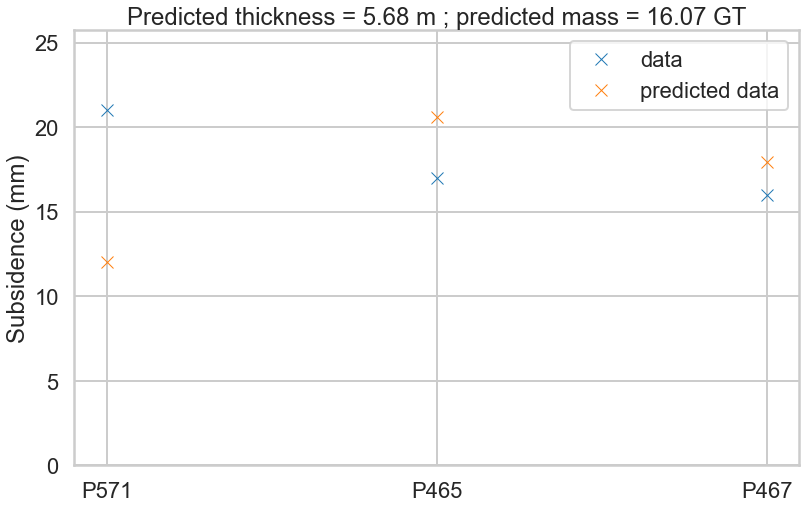

In [90]:
data = np.array([21e-3,17e-3,16e-3])
distances = [45000,30500,33000]
stn_names = ['P571','P465','P467']

# construct G

G = np.zeros(len(data))

alpha_Sequoia = 30*10**3
sigma=lamda_gran+2*mew_gran
nabla=lamda_gran + mew_gran


for i in range(len(data)):
    G[i] = g* (sigma* distances[i] / (np.pi**2 * mew_gran * nabla * alpha_Sequoia**2)) * (special.ellipe((alpha_Sequoia/distances[i])**2) - (1 - (alpha_Sequoia/distances[i])**2) * special.ellipk((alpha_Sequoia/distances[i])**2)) 

# solve the problem!

m = np.matmul(G.T,data)/np.matmul(G.T,G)
thickness_pred= m / (1000* np.pi * alpha_Sequoia**2)
#m/10e12

sns.set_style('whitegrid')
fig,ax = plt.subplots(1,1,figsize=(13,8))
plt.plot(stn_names,data*10**3,'x',label='data')
plt.plot(stn_names,10**3*m*G,'x',label='predicted data')
plt.legend()
plt.ylabel('Subsidence (mm)')
plt.ylim([0,1.25*np.max(10**3*m*G)])
plt.title("Predicted thickness = %.2f m ; predicted mass = %.2f GT" % (thickness_pred,m/(10**12)))

